This notebook requires the following packages to execute. It is confirmed to work with:
- Pennylane version `0.22.0` (or later) 
- Braket SDK version `1.20.0` (or later)
- networkx version `2.6.3` (or later)

In [1]:
# import dependencies
import pennylane as qml
import networkx as nx
from matplotlib import pyplot as plt
from pennylane import qaoa
from pennylane import numpy as np
import braket._sdk as braket_sdk
from braket.jobs.image_uris import Framework, retrieve_image
from braket.jobs.local.local_job import LocalQuantumJob
from braket.aws import AwsQuantumTask, AwsSession, AwsQuantumJob
from braket.jobs.config import InstanceConfig
import time
import boto3
import matplotlib.pyplot as plt
from itertools import chain, combinations
from networkx.algorithms.approximation import maxcut

# check package versions
print("Current pennylane version", qml.__version__)
print("Current braket sdk version", braket_sdk.__version__)
print("Current networkx version", nx.__version__)

Current pennylane version 0.22.0
Current braket sdk version 1.20.0
Current networkx version 2.6.3


# Benchmarking QN-SPSA optimizer with Braket embedded simulator

This notebook aims to showcase the power of the Braket Jobs embedded simulator for research projects. With an example of how we implement and benchmark the QN-SPSA optimizer, a novel quantum optimization algorithm proposed by Gacon et al. [1], we provide our recommendations on how the embedded simulator could be best utilized. 

## Embedded simulator introduction
Embedded simulator enables Braket Jobs users to use the hosting EC2 instance of the Job for circuit simulation. Comparing to the option of the managed simulators ([SV1](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/devices/arn:aws:braket:::device/quantum-simulator/amazon/sv1), [TN1](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/devices/arn:aws:braket:::device/quantum-simulator/amazon/tn1), etc), the embedded simulators experience no network/communication overhead per task. Therefore, it allows users to simulate task-heavy workloads with small-to-intermediate-scale circuits with significantly reduced costs. In addition, it enables more advanced use cases of customizing ones own simulation with project-specific optimizations. 

For more detailed information and quick hands-on experience, refer to [this example notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/hybrid_jobs/4_Embedded_simulators_in_Braket_Jobs/Embedded_simulators_in_Braket_Jobs.ipynb).

## Background: QN-SPSA optimizer

In a hand-waving argument, quantum natural simultaneous perturbation stochastic approximation (QN-SPSA, proposed by Gacon et al. [1]) is a second-order SPSA algorithm. 

The update rule of a vanilla gradient descent (GD) is written as:

\begin{equation}
x_{t + 1} = x_{t} - \eta \nabla f(x_t) \label{eq:vanilla}\tag{1}
\end{equation}


For quantum circuits, the gradient $\nabla f(x_t)$ is then estimated dimension by dimension, requiring $O(d)$ quantum measurements ($d$ being the dimension of the parameter space). As quantum measurements are expensive, this scaling makes GD impractical when dealing with high-dimensional complicated circuits.

SPSA replaces this dimension-wise gradient estimation with a stochastic one [2]. In SPSA, a randomly sampled direction is used to provide a finite-difference approximation on the gradient. Although this stochastic approach cannot provide a step-wise unbiased gradient estimation, SPSA is proved to be especially effective when accumulated over multiple optimization steps.

On the other hand, quantum natural gradient descent (QNG) is a variant of gradient descent. It introduces the Fubini-Study metric tensor $g$ [4] into the optimization to account for the structure of the non-Euclidean parameter space [5]. The $d$-by-$d$ metric tensor is defined as

$$
g = -\frac{1}{2} \frac{\partial}{\partial \alpha} \frac{\partial}{\partial \beta} \bigr\rvert\langle \phi(\alpha) | \phi(\beta) \rangle \bigr\rvert ^ 2\biggr\rvert_{\alpha=\beta},\label{eq:fs_tensor}\tag{2}
$$

where $\phi(x)$ is the parameterized ansatz with parameters $x$. With the metric tensor, the update rule is rewritten as:

\begin{align}
x_{t + 1} = x_{t} - \eta g^{-1}\nabla f(x_t) \label{eq:qn}\tag{3}
\end{align}

While the introduction of the metric tensor helps the optimization [3], the algorithm is not as scalable due to the number of measurements required to estimate $g$.

QN-SPSA manages to combine the merits of both QNG and SPSA by estimating both the gradient and the metric tensor stochastically. The gradient is estimated in the same fashion as the SPSA algorithm, while the Fubini-Study metric is computed by a second-order process with another two stochastic perturbations. This $O(1)$ update rule could fit into NISQ devices well. 

## Implementation and notebook test
I start with implementing the QN-SPSA algorithm using Pennylane, and this prototype is done in the Braket notebook environment. I find the notebook a quite handy tool for this purpose. It is deployed with the necessary packages, saving me time to set up the environment on my local device. 
It is also quite cheap. A notebook instance of `ml.t3.medium` is sufficient to test and debug on a small scale, and it costs me merely a few cents per hour. 

The optimizer class is present in `source_scripts/QNSPSA.py`. It follows Pennylane's convention for [optimizers](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html), with two class methods exposed to the users:

- `opt.step(loss_fn, parameters)` returns the updated parameters after one step of QN-SPSA optimization.
- `opt.step_and_cost(loss_fn, parameters)` returns the updated parameter after one step, along with the loss value before the update.

In [2]:
!cat source_scripts/QNSPSA.py

import random
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import sqrtm


class QNSPSA:
    """Quantum natural SPSA optimizer. Refer to https://arxiv.org/abs/2103.09232
    for a detailed description of the methodology. When disable_metric_tensor
    is set to be True, the metric tensor estimation is disabled, and QNSPSA is
    reduced to be a SPSA optimizer.
        
    Args:
        lr (float): The learn rate.
        regularization (float): Regularitzation term to the Fubini-Study
            metric tensor for numerical stability.
        finite_diff_step (float): step size to compute the finite difference 
            gradient and the Fubini-Study metric tensor.
        resamplings (int): The number of samples to average for each parameter 
            update.
        blocking (boolean): When set to be True, the optimizer only accept 
            updates that leads to a loss value no larger than the loss value
            before update, plus a tolera

To confirm the optimizer works, here I choose to work with a QAOA example on a toy maximum cut problem [6]. 

The maximum cut problem is partitioning the nodes of a graph into two subsets such that the number of edges going between the subsets is maximized. The next cell sets up the max cut problem. 

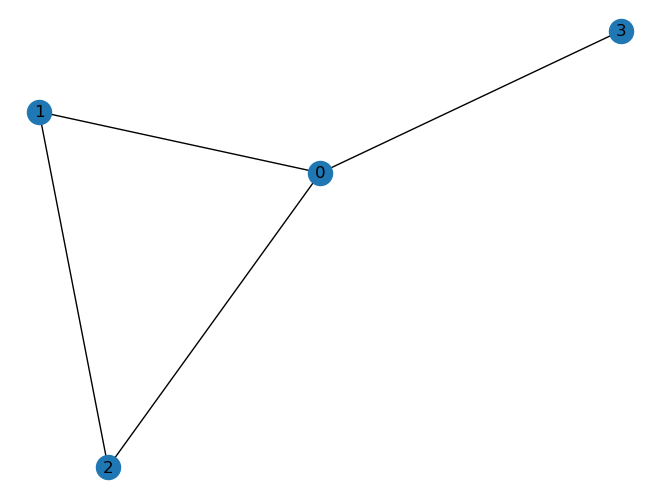

In [3]:
#intialize a graph for the max cut problem
nodes = n_qubits = 4
edges = 4
seed = 1

g = nx.gnm_random_graph(nodes, edges, seed=seed)
positions = nx.spring_layout(g, seed=seed)

#visualize the graph
nx.draw(g, with_labels=True, pos=positions)
plt.show()

The QAOA algorithm is an efficient hybrid algorithm solving combinatorial optimization problems such as max cut. In QAOA, finding the solution to the problem is mapped to finding the ground state of a specific Hamiltonian in a variational fashion.

Pennylane's QAOA module provides support for setting up the max cut problem from a given graph (See [this page](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.qaoa.cost.maxcut.html) to learn more about the QAOA module).

In [4]:
cost_h, mixer_h = qaoa.maxcut(g)
print("Cost Hamiltonian:")
print(cost_h)

print("Cost Hamiltonian:")
print(mixer_h)

Cost Hamiltonian:
  (-2.0) [I0]
+ (0.5) [Z0 Z1]
+ (0.5) [Z0 Z2]
+ (0.5) [Z0 Z3]
+ (0.5) [Z1 Z2]
Cost Hamiltonian:
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


Here the expectation of the cost Hamiltonian is bounded to be not greater than 0. Its absolute value (rounded to integer) means how many edges there are between the two subsets of a given cut, while the two subsets are specified by the $Z$ values of each qubit (node). Nodes with the same $Z$ value are of the same subset. Finding the maximum cut is then equivalent to finding the mininum-energy state of the cost Hamiltonian, and this is done with a hybrid algorithm with the QAOA ansatz.

The building block of the QAOA ansatz is a cost layer followed with a mixer layer. This building block repeats for $p$ times. The cost layer is formed of rotations from the problem Hamiltonian, while the mixer layer is typically chosen to be x-rotation gates on the qubits. This ansatz for $p=2$ is visualized in the following cells.

In [5]:
depth = 2
# Defining device to be the pennylane lightning local simulator
dev = qml.device("lightning.qubit", wires=n_qubits)

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)
    
def qaoa_circuit(params, n_qubits, depth):
    #initalizing all qubits into +X eigenstate. 
    for w in range(n_qubits):
        qml.Hadamard(wires=w)
    gammas = params[0]
    alphas = params[1]
    #stacking building blocks for depth times.
    qml.layer(qaoa_layer, depth, gammas, alphas)
    
# Defining ansatz and loss function
@qml.qnode(dev)
def cost_function(params):
    qaoa_circuit(params, n_qubits, depth)
    return qml.expval(cost_h) 

# Initializing parameters
params_init = 2 * np.pi * (np.random.rand(2, depth) - 0.5) 
# Visualizing the QAOA circuit 
drawer = qml.draw(cost_function)
print(drawer(params_init))

0: ──H─╭RZZ(-0.68)─╭RZZ(-0.68)─╭RZZ(-0.68)──RX(-2.21)─────────────╭RZZ(-2.63)─╭RZZ(-2.63)
1: ──H─╰RZZ(-0.68)─│───────────│───────────╭RZZ(-0.68)──RX(-2.21)─╰RZZ(-2.63)─│──────────
2: ──H─────────────╰RZZ(-0.68)─│───────────╰RZZ(-0.68)──RX(-2.21)─────────────╰RZZ(-2.63)
3: ──H─────────────────────────╰RZZ(-0.68)──RX(-2.21)────────────────────────────────────

──╭RZZ(-2.63)──RX(2.87)─────────────┤ ╭<𝓗>
──│───────────╭RZZ(-2.63)──RX(2.87)─┤ ├<𝓗>
──│───────────╰RZZ(-2.63)──RX(2.87)─┤ ├<𝓗>
──╰RZZ(-2.63)──RX(2.87)─────────────┤ ╰<𝓗>


Now I would like to see if my optimizer indeed reduces the loss.

In [6]:
# import the QN-SPSA optimizer
from source_scripts.QNSPSA import QNSPSA
# Optimize with QN-SPSA
opt = QNSPSA(lr=5e-2)
params = params_init
for i in range(300):
    params, loss = opt.step_and_cost(cost_function, params)
    if i % 40 == 0:
        print(f"Step {i}: cost = {loss:.4f}")

Step 0: cost = -2.5116
Step 40: cost = -2.7121
Step 80: cost = -2.7380
Step 120: cost = -2.9003
Step 160: cost = -2.9015
Step 200: cost = -2.9021
Step 240: cost = -2.9035
Step 280: cost = -2.9035


The analytical solution to the toy example gives a global minimum of -3. As the loss drops and finally converges close to the global minimum, we can tell that the optimizer works! 

## Benchmarking
I will now proceed to benchmark the QN-SPSA optimizer's performance with the QAOA problem. I follow a similar procedure with Ref [1] to compare the performance of QN-SPSA, SPSA, vanilla gradient descent and quantum natural gradient descent, as they are similar to each other. 

I choose to perform the benchmarking tests with Braket Jobs using the embedded simulator. When compared to the Braket notebooks, Braket Jobs has a few advantages for this benchmarking stage:

- First, I would like my benchmarking tests to be reproducible, which requires a systematic way to track the logs and the outputs. This is easily done with Braket Jobs. With the notebook, I would run into connection/permission timeout issues when the execution time of my program goes up to a few hours. I could easily lose the returned results or printed logs due to this issue. 

- Second, for tests on a larger scale with larger quantum circuits, I will likely need larger instances, with more abundant memory and computing power. For those more expensive instances, to be frugal, I would like to be charge only for the hours when my code is running. I would not be able to turn off the notebook instance at 3 am right after its execution, but Braket Jobs automatically do so to the Job instances.

Yet I will start with creating a working sample in the Braket Jobs local mode (`LocalQuantumJob`), instead of directly proceeding to execute it remotely (`AwsQuantumJob`). Braket service needs to prepare the environment (Docker container) for each remote Job I submit, and this process typically takes up to a few minutes. On the other hand, with the local mode, the environment only needs to be prepared once during my first call. I can fail fast and iterate with the local mode, and move to the remote Jobs after debugging to better utilize its power.

In [7]:
# Retrieve one of the default images (environment), with pennylane pre-installed
region_name = "us-east-1" # Change the region as needed
braket_client = boto3.client("braket", region_name=region_name)
aws_session = AwsSession(braket_client=braket_client)
image_uri = retrieve_image(Framework.BASE, region_name)
print(image_uri)

292282985366.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-base-jobs:1.0-cpu-py37-ubuntu18.04


Script `source_scripts/benchmark_qaoa_converge_speed` tests the performance of the four optimizers with the QAOA maxcut problem described above. The problem graph is defined with a node number of `n_qubits` and an edge number of `edges`. As Pennylane does not provide a direct implementation on SPSA, by disabling the tensor metric estimation in QN-SPSA, I created an SPSA optimizer. In the script, I have adjusted the learning rates to optimize each of the optimizers' performance (tested separately). Considering the stochastic nature of SPSA and QN-SPSA, they are each repeated `spsa_repeats` times to capture the average performance. The below cell confirms that the Job works.

In [8]:
%%time
n_qubits = 4
edges = 5
depth = 2
shots = 1000
seed = 1
load_init_config = False
max_iter = 100
spsa_repeats = 2

hyperparameters = {
    "n_qubits": n_qubits,
    "edges": edges,
    "depth": depth,
    "shots": shots,
    "seed": seed,
    "load_init_config": load_init_config,
    "max_iter": max_iter,
    "spsa_repeats": spsa_repeats,
}

# This cell should take about 2 min for the first time, 
# and about 30 seconds afterward.

job = LocalQuantumJob.create(
    device="local:pennylane/lightning.qubit",
    source_module="source_scripts",
    entry_point="source_scripts.benchmark_qaoa_converge_speed",
    job_name="local-embedded-simulation-" + str(int(time.time())),
    hyperparameters=hyperparameters,
    image_uri=image_uri,
)

Boto3 Version:  1.22.7
Beginning Setup
Running Code As Subprocess
0.23.0
{'n_qubits': '4', 'edges': '5', 'depth': '2', 'shots': '1000', 'seed': '1', 'load_init_config': 'False', 'max_iter': '100', 'spsa_repeats': '2'}
Using local simulator:  Lightning Qubit PennyLane plugin

Gradient descent optimizer:
Step 0:  loss = -2.55
Step 20:  loss = -3.17
Step 40:  loss = -3.23
Step 60:  loss = -3.21
Step 80:  loss = -3.21

Quantum natural gradient optimizer:
Step 0:  loss = -2.55
Step 20:  loss = -3.20
Step 40:  loss = -3.25
Step 60:  loss = -3.24
Step 80:  loss = -3.20

QN-SPSA optimizer:
Trace 0:
Step 0:  loss = -2.54
Step 20:  loss = -2.72
Step 40:  loss = -3.06
Step 60:  loss = -3.11
Step 80:  loss = -3.15
Trace 1:
Step 0:  loss = -2.56
Step 20:  loss = -2.91
Step 40:  loss = -3.06
Step 60:  loss = -3.12
Step 80:  loss = -3.54

SPSA optimizer:
Trace 0:
Step 0:  loss = -2.62
Step 20:  loss = -3.14
Step 40:  loss = -3.06
Step 60:  loss = -3.16
Step 80:  loss = -3.07
Trace 1:
Step 0:  loss = 

Note that each local Job will create a folder under the current path storing the log and result. This feature would be helpful if I needed to understand the details of my past runs. Feel free to delete them as needed.

I will now scale up the benchmarking test with a remote Job on 10 qubits and 2 layers. To make sure that my results are reproducible, I save a copy of the parameter/gate initialization result with the following cell. 

In [9]:
n_qubits = 10
depth = 2

params_init = 2 * np.pi * (np.random.rand(2, depth) - 0.5) 
   
np.save(
    f"source_scripts/qaoa_params_init_{n_qubits}_qubits_{depth}_layers.npy", 
    params_init
)

After all the preparation, finally it is time to run the benchmarking experiment with a remote Job. Here I decide to use a slightly larger instance of `ml.m5.large`.

In [10]:
n_qubits = 10
depth = 2
edges = 20
shots = 8192
load_init_config = True
max_iter = 400
spsa_repeats = 20
seed = 197


hyperparameters = {
    "n_qubits": n_qubits,
    "edges": edges,
    "depth": depth,
    "shots": shots,
    "seed": seed,
    "load_init_config": load_init_config,
    "max_iter": max_iter,
    "spsa_repeats": spsa_repeats,
}

job_name = f"qaoa-benchmark-qubit{n_qubits}-" + str(int(time.time()))
instance_config = InstanceConfig(instanceType='ml.m5.large', volumeSizeInGb=30, instanceCount=1)

job = AwsQuantumJob.create(
    device="local:pennylane/lightning.qubit",
    source_module="source_scripts",
    entry_point="source_scripts.benchmark_qaoa_converge_speed",
    job_name=job_name,
    hyperparameters=hyperparameters,
    instance_config=instance_config,
    image_uri=image_uri,
    wait_until_complete=False,
    aws_session=aws_session
)

Each remote Job has an unique identifier, referred as the Job ARN. You can always retrieve the ARN of your Jobs from the Jobs tab of the Amazon Braket console. It is also recommended to keep a copy of the Job ARN to pull the result at a later time. 

In [11]:
job_arn = job.arn
print(job_arn)

arn:aws:braket:us-east-1:298361590649:job/qaoa-benchmark-qubit10-1652321171

This remote Job above takes about 2.5 hours to finish. Taking into account the instance of `ml.m5.large` I choose, I can estimate my bill to be ~$0.25. 

The following line returns the Job result the time it is ready.

In [12]:
results = AwsQuantumJob(job_arn).result()

I can now process the result and visualize the performance of each optimizer.

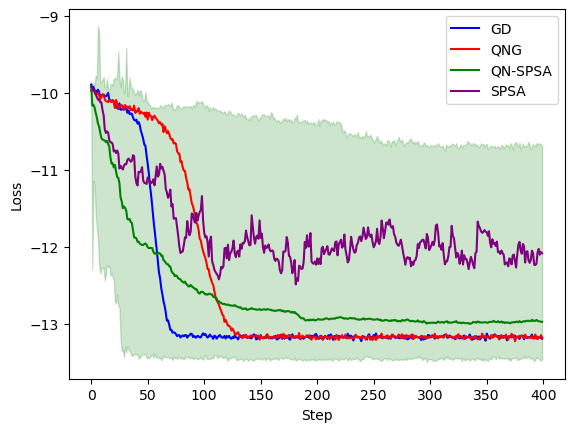

In [13]:
step = range(max_iter)
loss_gd = np.array(results['gd_loss_per_iter'])
loss_qng = np.array(results['qng_loss_per_iter'])

qnspsa_loss = np.array(results['qnspsa_loss_per_iter'])
qnspsa_loss_mean = np.mean(qnspsa_loss, axis=0)
qnspsa_loss_max = np.max(qnspsa_loss, axis=0)
qnspsa_loss_min = np.min(qnspsa_loss, axis=0)

spsa_loss = np.array(results['spsa_loss_per_iter'])
spsa_loss_mean = np.mean(spsa_loss, axis=0)
spsa_loss_max = np.max(spsa_loss, axis=0)
spsa_loss_min = np.min(spsa_loss, axis=0)

fig, ax = plt.subplots()

ax.plot(
    step, loss_gd, 'b', 
    step, loss_qng, 'r', 
    step, qnspsa_loss_mean, 'g',
    step, spsa_loss_mean, 'purple',
)

ax.fill_between(step, qnspsa_loss_min, qnspsa_loss_max, color='g', alpha=.2)
#SPSA envelope removed for better visualization
#ax.fill_between(step, spsa_loss_min, spsa_loss_max, color='purple', alpha=.2)
ax.legend(['GD', 'QNG', 'QN-SPSA', 'SPSA'])#, 'ground energy'])
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plt.show()

The above plot shows how the loss function drops over optimization steps. The purple/green solid line represents the average of the `spsa_repeats` number of curves for SPSA/QN-SPSA. The green shaded area stands for the envelope of all `spsa_repeats` curves for QN-SPSA. The envelope of the SPSA is not plotted since it is too noisy to visualize. 

SPSA turns out to provide really noisy results for such a use case. On the other hand, GD, QNG and QN-SPSA are able to minimize the loss function to be below -13, giving a estimated ground state of -14 for the max cut problem. I would like to understand how good they are doing finding the global minimum. Luckily for a 10-node graph, it is possible to loop through all possibilities to find the analytical ground state to the max cut problem. In this example, the ground state engergy is -16, as given by the following paragraph. 

In [14]:
nodes = n_qubits = 10
edges = 20
seed = 197

g = nx.gnm_random_graph(nodes, edges, seed=seed)

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

max_cut = 0
for S in powerset(range(nodes)): 
    temp_cut = nx.cut_size(g, S)
    if max_cut < temp_cut:
        max_cut = temp_cut
print("The theoretical ground state of the max cut problem is", -max_cut)

The theoretical ground state of the max cut problem is -16


Recall that QAOA only provides an approximated result to the ground-state energy (that's why it is named "Approximate"), the GD, QNG and QN-SPSA perform reasonably well minimizing the loss function. Yet I will not draw a simple conclusion here on which optimizer is better finding the global minimum. The max cut problem gives a non-convex and complex landscape, and the optimization result highly depends on the graph structure and the initialization (Feel free to rerun the experiment above with a different seed to see this effect). In my different experiment trials with different graph structures, I notice that GD and QNG sometimes get stuck with local minima and fail to further optimize, while QN-SPSA appears to be more consistent in minimizing the loss function. 

Another factor we have not discussed is the step-wise execution time for the different optimizers. I now pull out this information saved during experiment:

In [15]:
print(f'QNSPSA takes %.2f s per step' % (results['qnspsa_duration'] / spsa_repeats / max_iter))
print(f'SPSA takes %.2f s per step' % (results['spsa_duration'] / spsa_repeats / max_iter))
print(f'QNG takes %.2f s per step' % (results['qng_duration'] / max_iter))
print(f'GD takes %.2f s per step' % (results['gd_duration'] / max_iter))

QNSPSA takes 0.43 s per step
SPSA takes 0.21 s per step
QNG takes 4.74 s per step
GD takes 4.16 s per step


We can see the obvious advantage of the stochasitc optimizers (SPSA and QN-SPSA) in their execution time. Note that there are only 4 parameters in a depth-2 QAOA ansatz, yet it takes 10X more time for the gradient-based optimizers to finish a single optimization step, comparing to QN-SPSA (20X comparing to SPSA). The reason is that estimating the gradient with parameter shift rule requires to run 2$n_G$ circuits, where $n_G$ is the number of gates. The QAOA ansatz has limited parameters, but a rather large amount of gates applied. On the other hand, stochastic methods always execute a fixed number of circuits for each step. Combining the execution time observation with the optmization result, we can then clearly see the advantage of QN-SPSA in this use case.

Just as an additional sanity check, I also reproduce the experiment result in Fig 1(b) from Ref. [1] (Refer to Ref. [1] for the definition of the problem Hamiltonian and the ansatz). The  script `benchmark_ref_paper_converge_speed.py` for training, and the following two paragraphs take 70 min to finish.

In [16]:
# The execution time of the commented paragraph is about 70 min, and charges about $0.1.
# Please confirm the budget before uncommenting and running it.
"""
n_qubits = 11
n_layers = 4
shots = 8192
max_iter = 600
learn_rate = 1e-2
spsa_repeats = 25

hyperparameters = {
    "n_qubits": n_qubits,
    "n_layers": n_layers,
    "shots": shots,
    "max_iter": max_iter,
    "learn_rate": learn_rate,
    "spsa_repeats": spsa_repeats,
}

job_name = f"ref-paper-benchmark-qubit{n_qubits}-" + str(int(time.time()))
instance_config = InstanceConfig(instanceType='ml.m5.large', volumeSizeInGb=30, instanceCount=1)

job = AwsQuantumJob.create(
    device="local:pennylane/lightning.qubit",
    source_module="source_scripts",
    entry_point="source_scripts.benchmark_ref_paper_converge_speed",
    job_name=job_name,
    hyperparameters=hyperparameters,
    instance_config=instance_config,
    image_uri=image_uri,
    wait_until_complete=False,
)
"""

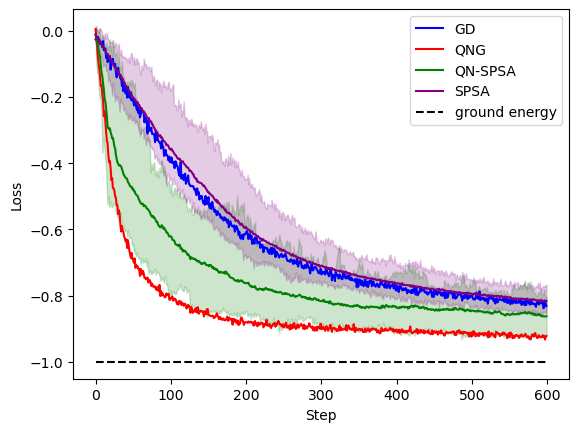

In [17]:
results = job.result()
step = range(max_iter)
loss_gd = np.array(results['gd_loss_per_iter'])
loss_qng = np.array(results['qng_loss_per_iter'])

qnspsa_loss = np.array(results['qnspsa_loss_per_iter'])
qnspsa_loss_mean = np.mean(qnspsa_loss, axis=0)
qnspsa_loss_max = np.max(qnspsa_loss, axis=0)
qnspsa_loss_min = np.min(qnspsa_loss, axis=0)

spsa_loss = np.array(results['spsa_loss_per_iter'])
spsa_loss_mean = np.mean(spsa_loss, axis=0)
spsa_loss_max = np.max(spsa_loss, axis=0)
spsa_loss_min = np.min(spsa_loss, axis=0)

ground_energy = -np.ones(max_iter)

fig, ax = plt.subplots()

ax.plot(
    step, loss_gd, 'b', 
    step, loss_qng, 'r', 
    step, qnspsa_loss_mean, 'g',
    step, spsa_loss_mean, 'purple',
)

ax.plot(step, ground_energy, linestyle='dashed', color='k')

ax.fill_between(step, qnspsa_loss_min, qnspsa_loss_max, color='g', alpha=.2)
ax.fill_between(step, spsa_loss_min, spsa_loss_max, color='purple', alpha=.2)
ax.legend(['GD', 'QNG', 'QN-SPSA', 'SPSA', 'ground energy'])
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plt.show()

In the plot, the observations from Gacon et al. [1] are reproduced. This confirms my implementation of the optimizer. In this exmaple with a simplier landscape, the average behavior of SPSA matches the one from GD. QN-SPSA outperforms the two both in the final loss value and in the step-wise convergence speed. Step-wise speaking, QNG performs the best among the 4 candidates, yet when taking into consideration step-wise execution time, QN-SPSA shows up as a very promising candidate for complicated VQE problems.

## Significant advantage on large problems

I would also like to confirm how well the optimizer works for a larger system. For that, I do the following stress test with a larger graph of 22 nodes and 44 edges. The QN-SPSA optimizer takes 30 sec per step, and 3 hours overall to finish the optimization (single trace). It takes a GD optimizer more than 13 min to finish a single optimization step for a problem with this size. We can see that the analytical gradient estimation quickly become impractical when the system size gets larger. This is the regime where QN-SPSA demonstrates its full strength.

In [18]:
# The execution time of the commented paragraph is about 3 hours, and charges about $0.4.
# Please confirm the budget before uncommenting and running it.
"""
n_qubits = 22
depth = 2
edges = 44
shots = 8192
load_init_config = False
max_iter = 300
learn_rate = 1e-2
seed = 197


hyperparameters = {
    "n_qubits": n_qubits,
    "edges": edges,
    "depth": depth,
    "shots": shots,
    "seed": seed,
    "load_init_config": load_init_config,
    "max_iter": max_iter,
    "learn_rate": learn_rate,
}

instance_config = InstanceConfig(instanceType='ml.m5.2xlarge', volumeSizeInGb=30, instanceCount=1)



job_name = f"qaoa-stress-test-qubits{n_qubits}-" + str(int(time.time()))


jobs = AwsQuantumJob.create(
    device="local:pennylane/lightning.qubit",
    #device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    source_module="source_scripts",
    entry_point="source_scripts.qaoa_stress_test",
    job_name=job_name,
    hyperparameters=hyperparameters,
    instance_config=instance_config,
    image_uri=image_uri,
    wait_until_complete=False,
)
"""

The (single-trace) optimization result is shown in the following paragraph:

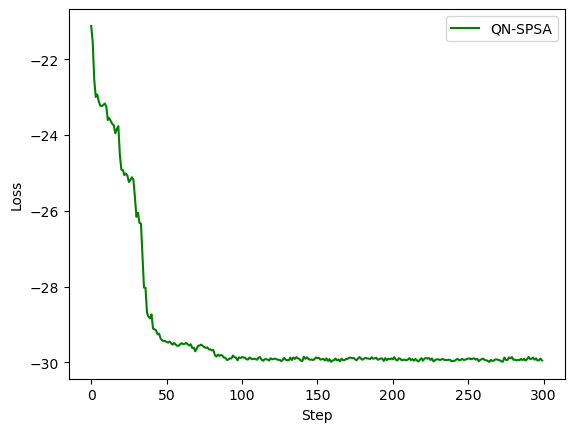

In [19]:
results = AwsQuantumJob('arn:aws:braket:us-east-1:298361590649:job/qaoa-stress-test-qubits22-1652382076').result()
step = range(300)

loss_qnspsa = results['qnspsa_loss_per_iter']

fig, ax = plt.subplots()

ax.plot(step, loss_qnspsa, 'g',)
ax.legend(['QN-SPSA'])
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
plt.show()

It takes about 2 min to find the theoretical solution to the 22-node graph. 

In [4]:
nodes = n_qubits = 22
edges = 44
seed = 197

g = nx.gnm_random_graph(nodes, edges, seed=seed)


def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

max_cut = 0
for S in powerset(range(nodes)): 
    temp_cut = nx.cut_size(g, S)
    if max_cut < temp_cut:
        max_cut = temp_cut
print("The theoretical ground state of the max cut problem is", -max_cut)

The theoretical ground state of the max cut problem is -35


To further improve the QAOA estimation from here, one could try to increase $p$ from 2 to a larger integer. As the simulator's execution time scales linearly with $p$, I would estimate a script execution time of 4.5h with $p$ increased from 2 to 3.

## Embedded simulator vs managed simulator
When going beyond 22 qubits, the embedded simulator option shows its limitation in computational power. The circuit simulation time becomes too long for larger systems. This is the regime where managed simulators show their advantages. Though introducing additional network/communication overhead per task, managed simulators support Pennylane's batch execution feature, in which multiple ciurcuits could be executed in parallel. As a result, the overall execution time of a QML/VQE program can be significantly reduced. 

To confirm this, with the `qaoa_stress_test` script, I change the device to the SV1 simulator (device ARN `arn:aws:braket:::device/quantum-simulator/amazon/sv1`) to test the execution time. For the same 22-qubit system, SV1 gives a step-wise optimization time of 12 sec, a factor of 2-3 faster than the embedded simulator. Therefore, I would recommend using managed simulator for large circuit simulations. Though it depends on the specific algorithm and ansatz to execute, a rule of thumb could be: try the managed simulators for systems with more than 25 qubits.

From a stress test with 29 qubits and 58 edges on an `ml.m5.4xlarge` instance using SV1 with the same script of `qaoa_stress_test`, I get a step-wise QN-SPSA execution time of 4 min. The whole optimization will then finish in about 20 hours. 

# Conclusion

In this notebook, we demonstrate an example of using Braket Jobs and the embedded simulator feature to study a novel optimizer. With the example, we show the research potential of the service, recommend a few best practices, and discuss the advantages and limitations of the embedded simulator.

# References
[1] Gacon, J., Zoufal, C., Carleo, G., & Woerner, S. (2021). *Simultaneous perturbation stochastic approximation of the quantum fisher information*. Quantum, 5, 567.

[2] Simultaneous perturbation stochastic approximation (2022). Wikipedia. https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximationhttps://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation

[3] Yamamoto, N. (2019). *On the natural gradient for variational quantum eigensolver*. arXiv preprint arXiv:1909.05074.

[4] Fubini–Study metric (2022). Wikipedia. https://en.wikipedia.org/wiki/Fubini%E2%80%93Study_metric

[5] Stokes, J., Izaac, J., Killoran, N., & Carleo, G. (2020). *Quantum natural gradient*. Quantum, 4, 269.

[6] Farhi, E., Goldstone, J., & Gutmann, S. (2014). *A quantum approximate optimization algorithm*. arXiv preprint arXiv:1411.4028.
  
